# Nathan Notebook
Experimentation with preprocessing, binary classification, multiclassification

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# Tensorflow/keras imports
from keras import Sequential
from keras import layers
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

In [3]:
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

In [4]:
# Data files
# Train
train_df = pd.read_csv("UNSW_NB15_training-set.csv")
# Test
test_df = pd.read_csv("UNSW_NB15_testing-set.csv")

## Data Preprocessing: Missing data, Encoding

In [5]:
# Note: There are no missing values in the train or test sets
# Train
train_df = train_df.dropna()
# Test
test_df = test_df.dropna()

In [6]:
# Create train and test dataframes for binary classification
# Train
X_train = train_df.drop(columns=["id", "attack_cat"])
y_train = X_train.pop("label")
# Test
X_test = test_df.drop(columns=["id", "attack_cat"])
y_test = X_test.pop("label")

In [7]:
# Remove features that might not generalize well
# Train
# X_train.drop(['srcip', 'dstip', 'Stime', 'Ltime'], axis=1, inplace=True) # Already removed in original data
# Test
# X_test.drop(['srcip', 'dstip', 'Stime', 'Ltime'], axis=1, inplace=True) # Already removed in original data

In [8]:
# Convert binary nominal features to integer
# Train
X_train['is_sm_ips_ports'] = X_train['is_sm_ips_ports'].astype(int)
X_train['is_ftp_login'] = X_train['is_ftp_login'].astype(int)
# Test
X_test['is_sm_ips_ports'] = X_test['is_sm_ips_ports'].astype(int)
X_test['is_ftp_login'] = X_test['is_ftp_login'].astype(int)

### Handling nominal feature: 'proto'

Number of unique values in proto: 133
proto
tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
          ...  
rdp          98
netblt       98
igmp         18
icmp         15
rtp           1
Name: count, Length: 133, dtype: int64


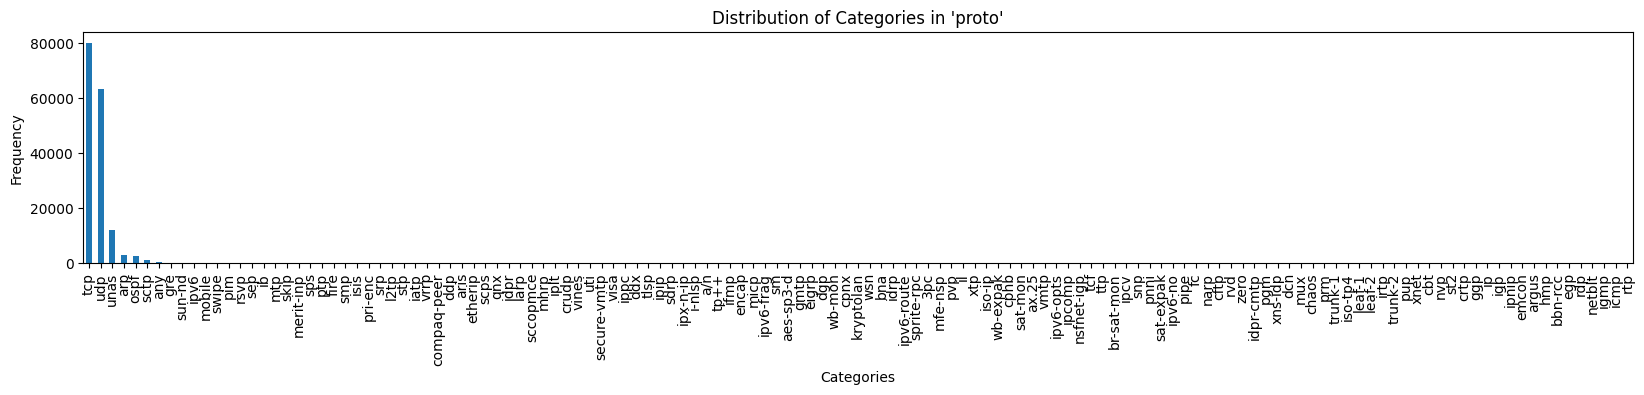

In [9]:
# Determine encoding scheme for 'proto' feature
num_categories = X_train['proto'].nunique()
categories = X_train['proto'].unique();
print(f'Number of unique values in proto: {num_categories}')
# print(f'  {categories}') # There's a lot of categories

# Show frequency of unique values:
category_counts = X_train['proto'].value_counts()
print(category_counts)

# Plotting frequency of each 'proto' category
plt.figure(figsize=(20, 3))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in \'proto\'')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate category labels for better readability
plt.show()

### Handling nominal feature: 'state'

Number of unique values in state: 9
  ['FIN' 'INT' 'CON' 'ECO' 'REQ' 'RST' 'PAR' 'URN' 'no']
state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64


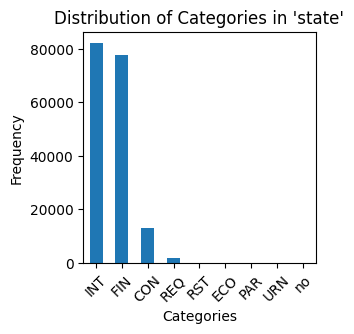

In [10]:
# Determine encoding scheme for 'state' feature
num_categories = X_train['state'].nunique()
categories = X_train['state'].unique();
print(f'Number of unique values in state: {num_categories}')
print(f'  {categories}')

# Show frequency of unique values:
category_counts = X_train['state'].value_counts()
print(category_counts)

# Plotting frequency of each 'state' category
plt.figure(figsize=(3, 3))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in \'state\'')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.show()

### Handling nominal feature: 'service'

Number of unique values in service: 13
  ['-' 'ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3'
 'dhcp' 'ssl' 'irc']
service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: count, dtype: int64


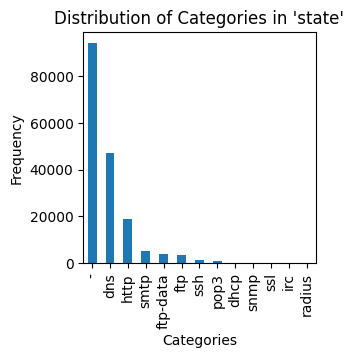

In [11]:
# Determine encoding scheme for 'service' feature
num_categories = X_train['service'].nunique()
categories = X_train['service'].unique();
print(f'Number of unique values in service: {num_categories}')
print(f'  {categories}')

# Show frequency of unique values:
category_counts = X_train['service'].value_counts()
print(category_counts)

# Plotting frequency of each 'service' category
plt.figure(figsize=(3, 3))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in \'state\'')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=90) # Better readability
plt.show()

### Pre-encoding: Aggregate for 'proto', 'state', and 'service'

In [12]:
nominal_features = ['proto', 'state', 'service']

# If category does not comprise at least 1 percent of total data (can change this), set it to 'other' category
for nf in nominal_features:
    
    # Aggregate for training set
    frequency = X_train[nf].value_counts()
    categories = X_train[nf].unique();
    threshold_percentage = 0.01
    threshold = X_train.shape[0] * threshold_percentage;
    
    print(f'Performing aggregation for {nf} with threshold percentage: {threshold_percentage}')
    
    X_train[nf] = X_train[nf].apply(lambda x: x if frequency[x] > threshold else 'other')
    
    # See updated categories
    updated_categories = X_train[nf].unique();
    print(f'  Updated {nf} categories for train set: {updated_categories}')
    
    # Apply changes to testing set
    frequency = X_test[nf].value_counts()
    X_test[nf] = X_test[nf].apply(lambda x: x if x in updated_categories else 'other')
    print(f'  Updated {nf} categories for test set: {X_test[nf].unique()}\n')

Performing aggregation for proto with threshold percentage: 0.01
  Updated proto categories for train set: ['tcp' 'udp' 'arp' 'ospf' 'other' 'unas']
  Updated proto categories for test set: ['udp' 'arp' 'tcp' 'other' 'ospf' 'unas']

Performing aggregation for state with threshold percentage: 0.01
  Updated state categories for train set: ['FIN' 'INT' 'CON' 'other' 'REQ']
  Updated state categories for test set: ['INT' 'FIN' 'REQ' 'other' 'CON']

Performing aggregation for service with threshold percentage: 0.01
  Updated service categories for train set: ['-' 'ftp' 'smtp' 'other' 'http' 'ftp-data' 'dns']
  Updated service categories for test set: ['-' 'http' 'ftp' 'ftp-data' 'smtp' 'other' 'dns']



In [13]:
from category_encoders import BinaryEncoder

# Initialize Binary Encoder
encoder = BinaryEncoder(cols=['proto', 'state', 'service'], handle_unknown='ignore')

# Fit the encoder on the training data
X_train = encoder.fit_transform(X_train)

# Transform the testing data using the same encoder
X_test = encoder.transform(X_test)

print("Encoded Training Data:")
print(X_train)
print("\nEncoded Testing Data:")
print(X_test)

Encoded Training Data:
             dur  proto_0  proto_1  proto_2  service_0  service_1  service_2  \
0       0.121478        0        0        1          0          0          1   
1       0.649902        0        0        1          0          0          1   
2       1.623129        0        0        1          0          0          1   
3       1.681642        0        0        1          0          1          0   
4       0.449454        0        0        1          0          0          1   
...          ...      ...      ...      ...        ...        ...        ...   
175336  0.000009        0        1        0          1          1          1   
175337  0.505762        0        0        1          0          0          1   
175338  0.000009        0        1        0          1          1          1   
175339  0.000009        0        1        0          1          1          1   
175340  0.000009        0        1        0          1          1          1   

        state_0 

### PCA

## Training and Testing

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold

### Random Forest

In [15]:
print('Running: Random Forest Classifier...')

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the Random Forest classifier:', accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

Running: Random Forest Classifier...
Accuracy of the Random Forest classifier: 0.8722003595199922
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     37000
           1       0.82      0.99      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332



### Random Forest + K-Fold Cross-Validation

In [16]:
rf_clf = RandomForestClassifier(random_state=0)

# Setting up K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=kf, scoring='accuracy')

# Results from cross-validation
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
print("Standard deviation of CV scores:", np.std(cv_scores))

Cross-validation scores: [0.95922325 0.96141782 0.95873731 0.95745409 0.9606764 ]
Mean cross-validation score: 0.9595017724236021
Standard deviation of CV scores: 0.001407548392306528
